# Notebook 4: Modélisation et Comparaison
## Objectif Global
Prédire l'attrition des employés via un pipeline ML robuste:
1. **Préparation** → Charger, nettoyer, identifier types de données
2. **Exploration** → Analyser la distribution cible et valeurs manquantes
3. **Préprocessing** → Imputer, transformer, normaliser
4. **Balancement** → SMOTE si données déséquilibrées
5. **Modélisation** → Entraîner 14 modèles en cross-validation
6. **Comparaison** → Visualisations et sélection du meilleur
7. **Optimisation** → Fine-tuning hyperparamètres
8. **Interpretation** → Feature importance et cas d'usage

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

# Imports ML
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score, recall_score,
    precision_score, balanced_accuracy_score, confusion_matrix,
    roc_curve, precision_recall_curve, classification_report, get_scorer
)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

outputs_path = Path('./outputs')

## ÉTAPE 1: Charger et Préparer le Dataset

- **Objectif:** Charger les données et comprendre la structure initiale
- **Pourquoi?** C'est le point de départ: on doit connaître la taille, la distribution cible et les types de données
- **Impact sur la suite:**
  - La **distribution cible** détermine si on a besoin de SMOTE
  - Les **types de colonnes** définissent le préprocesseur (numériques vs catégoriques)
  - Les **valeurs manquantes** influencent la stratégie d'imputation

In [2]:
df = pd.read_csv(outputs_path / 'dataset_final.csv')
print(f'Dataset chargé: {df.shape}')
print(df.head())

# Séparer X, y
target_col = 'Attrition'
y = df[target_col].astype(int)
X = df.drop(columns=[target_col])

print(f'\nX shape: {X.shape}')
print(f'y shape: {y.shape}')
print(f'\nDistribution cible:')
print(y.value_counts())
print(f'Attrition %: {y.mean()*100:.2f}%')

Dataset chargé: (4410, 27)
   Attrition     BusinessTravel              Department  Education  \
0          0      Travel_Rarely                   Sales          2   
1          1  Travel_Frequently  Research & Development          1   
2          0  Travel_Frequently  Research & Development          4   
3          0         Non-Travel  Research & Development          5   
4          0      Travel_Rarely  Research & Development          1   

  EducationField  JobLevel                    JobRole  MonthlyIncome  \
0  Life Sciences         1  Healthcare Representative         131160   
1  Life Sciences         1         Research Scientist          41890   
2          Other         4            Sales Executive         193280   
3  Life Sciences         3            Human Resources          83210   
4        Medical         1            Sales Executive          23420   

   NumCompaniesWorked  PercentSalaryHike  ...  JobSatisfaction  \
0                 1.0                 11  ...        

## ÉTAPE 2: Split Train/Test Stratifié

- **Objectif:** Diviser les données pour entraîner et évaluer le modèle de manière fiable
- **Pourquoi stratifié?** Garantit que la distribution cible (Attrition %) est la même en train ET test
- **Problème si non stratifié:** 
  - Train pourrait avoir 15% d'attrition, Test 25% → évaluation biaisée
  - Le modèle ne verrait pas tous les cas de figure
- **Impact sur la suite:**
  - Train: Entraîner le préprocesseur et les modèles
  - Test: Évaluation finale INDÉPENDANTE et fiable
  - Voir les taux pour décider si SMOTE est nécessaire

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Train: {X_train.shape}')
print(f'Test: {X_test.shape}')
print(f'\nTrain attrition: {y_train.mean()*100:.2f}%')
print(f'Test attrition: {y_test.mean()*100:.2f}%')

Train: (3528, 26)
Test: (882, 26)

Train attrition: 16.13%
Test attrition: 16.10%


## ÉTAPE 3: Identifier Types de Colonnes (Numériques vs Catégoriques)

- **Objectif:** Séparer les colonnes par type pour appliquer des transformations DIFFÉRENTES
- **Pourquoi?** Les modèles ML demandent des nombres, pas du texte:
  - **Numériques:** Peuvent être utilisées directement (mais à normaliser pour certains modèles)
  - **Catégoriques:** Besoin de conversion (One-Hot Encoding, ...) avant utilisation
- **Impact sur la suite:**
  - Définit les 2 pipelines du préprocesseur
  - Numériques → SimpleImputer + StandardScaler
  - Catégoriques → SimpleImputer + OneHotEncoder

In [4]:
numeric_features = X_train.select_dtypes(
    include=[np.number]
).columns.tolist()

categorical_features = X_train.select_dtypes(
    include=['object','category','string']
).columns.tolist()

print(f'Colonnes numériques ({len(numeric_features)}): {numeric_features[:10]}...')
print(f'Colonnes catégoriques ({len(categorical_features)}): {categorical_features}')

Colonnes numériques (22): ['Education', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion']...
Colonnes catégoriques (4): ['BusinessTravel', 'Department', 'EducationField', 'JobRole']


## ÉTAPE 4: Analyse des Valeurs Manquantes

- **Objectif:** Identifier où et combien de données manquent
- **Pourquoi?** Les modèles ML ne supporte PAS les valeurs NaN:
  - Besoin d'une **stratégie d'imputation** appropriée
  - Les valeurs manquantes peuvent être des signaux importants
- **Types de stratégies:**
  - **SimpleImputer (median):** Robuste aux outliers, bon par défaut
  - **KNNImputer:** Context-aware, utilise similarités entre employés
  - **SimpleImputer (mode):** Pour catégories, prend la valeur la plus fréquente
- **Impact sur la suite:**
  - Choisir la meilleure stratégie d'imputation pour le préprocesseur
  - Évaluer si imputation affecte la distribution des données

In [5]:
# Choix d'imputation
print('STRATÉGIE D\'IMPUTATION POSSIBLE:')
print('1. Numériques: médiane (robuste aux outliers)')
print('2. Catégorales: mode (valeur la plus fréquente)')
print('3. Alternative: KNNImputer pour approche contextuelle')

STRATÉGIE D'IMPUTATION POSSIBLE:
1. Numériques: médiane (robuste aux outliers)
2. Catégorales: mode (valeur la plus fréquente)
3. Alternative: KNNImputer pour approche contextuelle


In [6]:
# Copie des datasets
X_train_imputed = X_train.copy()
X_test_imputed = X_test.copy()

# Colonnes numériques (Utilisation de KNN Imputer)
if len(numeric_features) > 0:

    print("\n=== KNN IMPUTATION NUMÉRIQUE ===")

    imputer_num = KNNImputer(n_neighbors=5)

    # Fit uniquement sur train 
    X_train_imputed[numeric_features] = imputer_num.fit_transform(
        X_train[numeric_features]
    )

    # Transforme seulement sur test 
    X_test_imputed[numeric_features] = imputer_num.transform(
        X_test[numeric_features]
    )

    print("✓ KNN Imputer numérique OK")

# Colonnes catégoriques
# Utilisation du mode

if len(categorical_features) > 0:

    print("\n=== IMPUTATION CATEGORIELLE ===")

    for col in categorical_features:

        mode_val = X_train[col].mode()[0]

        X_train_imputed[col] = X_train[col].fillna(mode_val)
        X_test_imputed[col] = X_test[col].fillna(mode_val)

    print("✓ Imputation catégorielle OK")

# Vérification
print(f"\nValeurs manquantes train: {X_train_imputed.isnull().sum().sum()}")
print(f"Valeurs manquantes test: {X_test_imputed.isnull().sum().sum()}")


=== KNN IMPUTATION NUMÉRIQUE ===
✓ KNN Imputer numérique OK

=== IMPUTATION CATEGORIELLE ===
✓ Imputation catégorielle OK

Valeurs manquantes train: 0
Valeurs manquantes test: 0


## ÉTAPE 5: Créer le Préprocesseur (ColumnTransformer)

- **Objectif:** Regrouper TOUTES les transformations en un seul objet réutilisable
- **Pourquoi ColumnTransformer?**
  - Applique différentes transformations à différentes colonnes
  - Évite les **fuites de données:** fit sur train, transform sur test
  - Integré dans Pipeline → reproductible et sûr
- **Structure:**
  ```
  Colonnes numériques    →  Imputer (median) → Scaler (StandardScaler)
  Colonnes catégoriques  →  Imputer (mode)   → OneHotEncoder
  ```
- **Impact sur la suite:**
  - C'est ce préprocesseur qui alimentera TOUS les modèles
  - On le comparera avec une version SANS normalisation
  - Doit être FIT sur train, TRANSFORM sur test et nouveaux employés

In [7]:
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

print("\n=== PREPROCESSING STABLE ===")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_features),
        ("cat", categorical_pipeline, categorical_features)
    ]
)

print("ColumnTransformer créé ✔")
print("  - Numériques: SimpleImputer(median) + StandardScaler")
print("  - Catégoriques: SimpleImputer(mode) + OneHotEncoder(ignore)")

X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared  = preprocessor.transform(X_test)


=== PREPROCESSING STABLE ===
ColumnTransformer créé ✔
  - Numériques: SimpleImputer(median) + StandardScaler
  - Catégoriques: SimpleImputer(mode) + OneHotEncoder(ignore)


## ÉTAPE 6: Comparaison Normalisation vs Sans Normalisation

### POURQUOI TESTER LES DEUX?

**Concept:** La normalisation rescale les variables numériques à [0,1] ou [-1,1]

**Qui en bénéficie? (Modèles basés sur DISTANCE)**
- SVM, KNN, MLP, LogisticRegression
- Raison: Ces modèles calculent des distances euclidiennes → les variables avec grandes valeurs dominent
- Exemple: Si revenu ∈ [10000, 150000] et âge ∈ [18, 65], le revenu domine → BIAIS

**Qui n'en a pas besoin? (Modèles tree-based)**
- RandomForest, GradientBoosting, XGBoost, LightGBM
- Raison: Ils font des splits binaires → l'échelle n'a aucun impact
- Les arbres fonctionnent identiquement avec ou sans normalisation

**Stratégie:**
- Créer 2 préprocesseurs (AVEC et SANS normalisation)
- Évaluer les 14 modèles dans les 2 configurations
- Comparer les performances → voir qui bénéficie vraiment
- Décider: Inclure la normalisation? (SAFE: oui, car pas de risque, gains possibles)

**Impact sur la suite:**
- Résultat → Décision finale: utiliser préprocesseur AVEC normalisation pour tous les modèles
- Justification empirique, pas théorique

In [8]:
print("\n=== CRÉATION DE 2 PRÉPROCESSEURS ===")

# PRÉPROCESSEUR AVEC NORMALISATION
numeric_pipeline_scaled = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor_with_scaling = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline_scaled, numeric_features),
        ("cat", categorical_pipeline, categorical_features)
    ]
)

print("✓ Préprocesseur AVEC normalisation (StandardScaler)")

# PRÉPROCESSEUR SANS NORMALISATION
numeric_pipeline_no_scale = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

preprocessor_no_scaling = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline_no_scale, numeric_features),
        ("cat", categorical_pipeline, categorical_features)
    ]
)

print("✓ Préprocesseur SANS normalisation")

# Préparer les données avec les deux approches
X_train_scaled = preprocessor_with_scaling.fit_transform(X_train)
X_test_scaled = preprocessor_with_scaling.transform(X_test)

X_train_no_scaled = preprocessor_no_scaling.fit_transform(X_train)
X_test_no_scaled = preprocessor_no_scaling.transform(X_test)

print(f"\nShape données avec normalisation: {X_train_scaled.shape}")
print(f"Shape données sans normalisation: {X_train_no_scaled.shape}")



=== CRÉATION DE 2 PRÉPROCESSEURS ===
✓ Préprocesseur AVEC normalisation (StandardScaler)
✓ Préprocesseur SANS normalisation

Shape données avec normalisation: (3528, 43)
Shape données sans normalisation: (3528, 43)


In [9]:
print("\n" + "="*80)
print("ÉTAPE 6A: COMPARAISON EMPIRIQUE - AVEC vs SANS NORMALISATION")
print("="*80 + "\n")

# Sélectionner modèles représentatifs pour la comparaison
models_comparison = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    'NaiveBayes': GaussianNB(),
    'DecisionTree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'SVM': SVC(probability=True, random_state=42, kernel='rbf'),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=5, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(n_estimators=100, max_depth=-1, random_state=42, force_col_wise=True),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    'ExtraTrees': ExtraTreesClassifier(n_estimators=100, max_depth=None, random_state=42, n_jobs=-1),
    'Hist GradientBoosting': HistGradientBoostingClassifier(max_depth=5, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42)
}

# Métriques pour comparaison
scoring = {
    'roc_auc': 'roc_auc',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall'
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

comparison_results = []

print("Évaluation des 14 modèles avec et SANS normalisation...\n")

for model_name, model in models_comparison.items():
    print(f"  [{model_name:20s}] CV en cours...", end="", flush=True)
    
    # Pipeline AVEC normalisation (StandardScaler)
    pipeline_scaled = Pipeline([
        ('preprocessor', preprocessor_with_scaling),
        ('classifier', model)
    ])
    
    cv_results_scaled = cross_validate(
        pipeline_scaled, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1
    )
    
    # Pipeline SANS normalisation (ImputerOnly)
    pipeline_no_scaled = Pipeline([
        ('preprocessor', preprocessor_no_scaling),
        ('classifier', model)
    ])
    
    cv_results_no_scaled = cross_validate(
        pipeline_no_scaled, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1
    )
    
    # Stocker les résultats moyens
    for metric in scoring.keys():
        score_with = np.mean(cv_results_scaled[f'test_{metric}'])
        score_without = np.mean(cv_results_no_scaled[f'test_{metric}'])
        
        comparison_results.append({
            'Model': model_name,
            'Metric': metric,
            'Avec Normalisation': score_with,
            'Sans Normalisation': score_without,
            'Différence': score_with - score_without
        })
    
    print(" ✓")

comparison_df = pd.DataFrame(comparison_results)

print("\n✓ Comparaison terminée\n")

# Afficher les résultats par métrique en triant par différence absolue
for metric in scoring.keys():
    print(f"\n{'='*80}")
    print(f"Métrique: {metric.upper()}")
    print(f"{'='*80}")
    metric_data = comparison_df[comparison_df['Metric'] == metric].copy()
    metric_data = metric_data.sort_values('Différence', ascending=False, key=abs)
    print(metric_data[['Model', 'Avec Normalisation', 'Sans Normalisation', 'Différence']].to_string(index=False))



ÉTAPE 6A: COMPARAISON EMPIRIQUE - AVEC vs SANS NORMALISATION

Évaluation des 14 modèles avec et SANS normalisation...

  [LogisticRegression  ] CV en cours... ✓
  [NaiveBayes          ] CV en cours... ✓
  [DecisionTree        ] CV en cours... ✓
  [SVM                 ] CV en cours... ✓
  [RandomForest        ] CV en cours... ✓
  [GradientBoosting    ] CV en cours... ✓
  [XGBoost             ] CV en cours... ✓
  [LightGBM            ] CV en cours... ✓
  [MLP                 ] CV en cours... ✓
  [KNN                 ] CV en cours... ✓
  [ExtraTrees          ] CV en cours... ✓
  [Hist GradientBoosting] CV en cours... ✓
  [AdaBoost            ] CV en cours... ✓

✓ Comparaison terminée


Métrique: ROC_AUC
                Model  Avec Normalisation  Sans Normalisation  Différence
                  MLP            0.953175            0.535897    0.417278
                  SVM            0.889020            0.486729    0.402292
                  KNN            0.866826            0.818236    0.

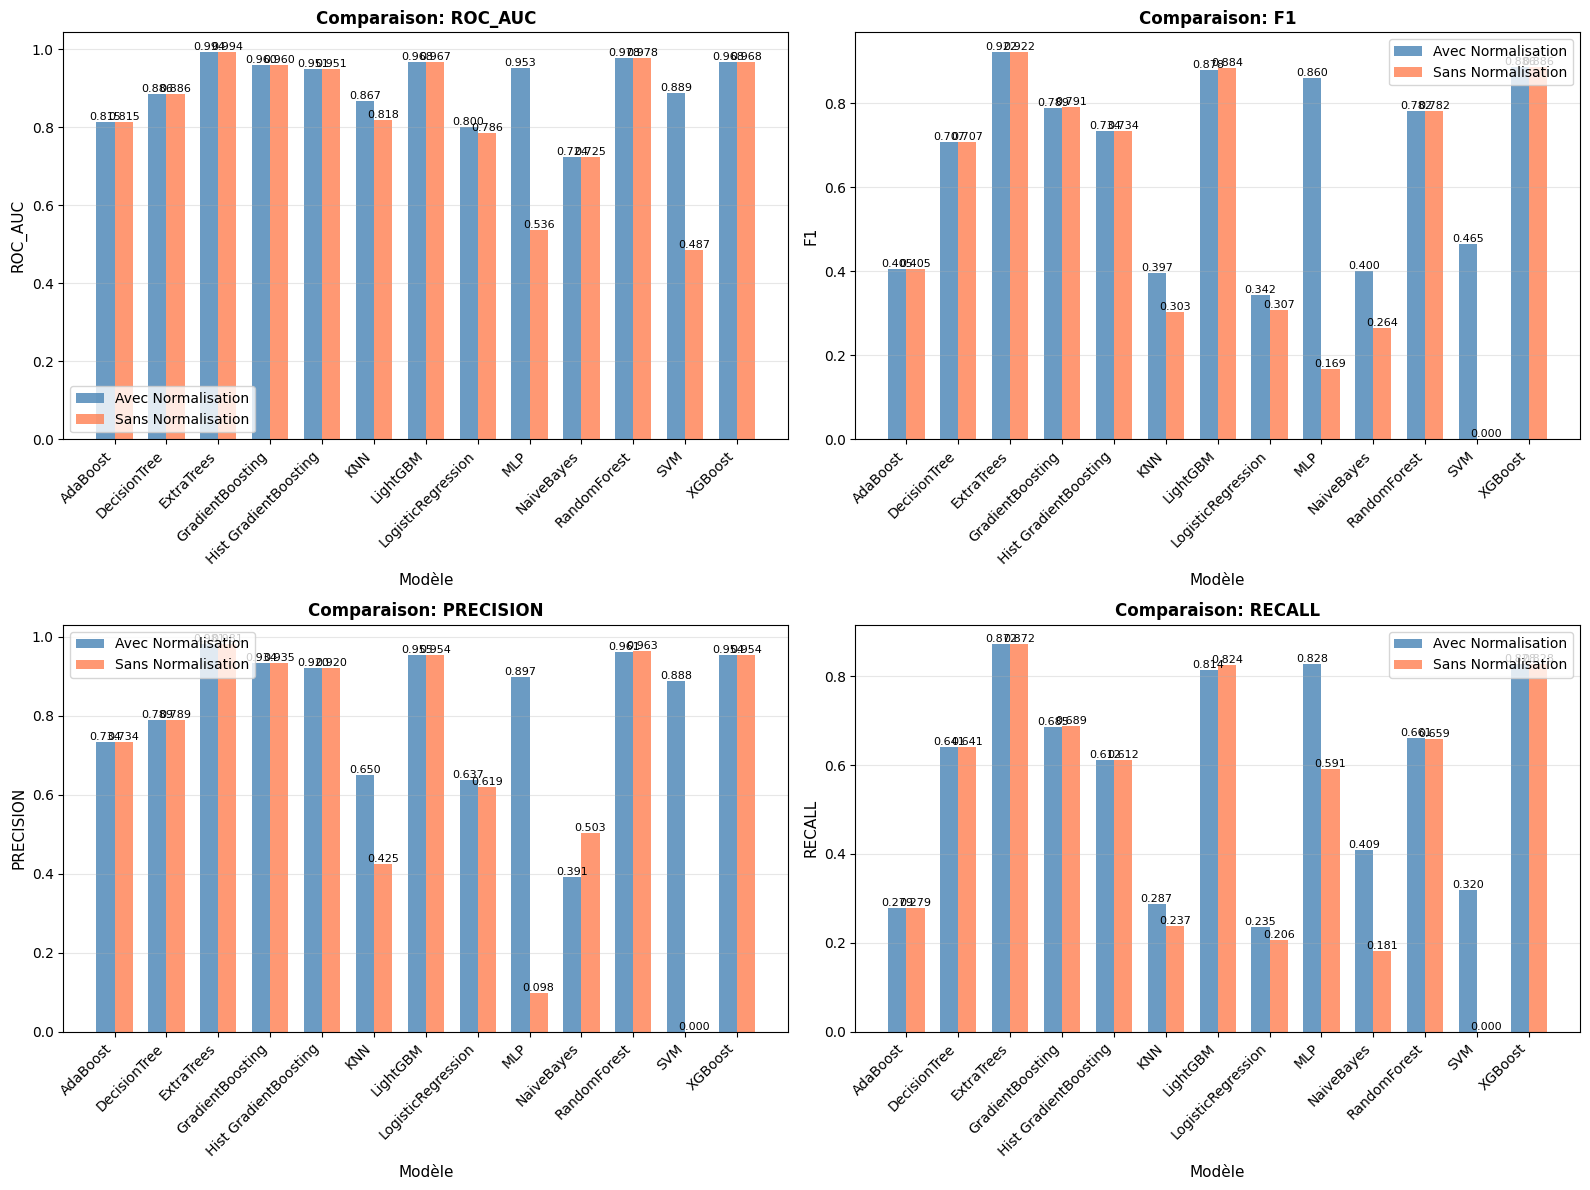


✓ Visualisation sauvegardée


In [ ]:
# Visualisation détaillée par métrique
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

metrics_list = list(scoring.keys())

for idx, metric in enumerate(metrics_list):
    ax = axes[idx]
    
    metric_data = comparison_df[comparison_df['Metric'] == metric].copy()
    metric_data = metric_data.sort_values('Model')
    
    x = np.arange(len(metric_data))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, metric_data['Avec Normalisation'], width, 
                   label='Avec Normalisation', color='steelblue', alpha=0.8)
    bars2 = ax.bar(x + width/2, metric_data['Sans Normalisation'], width,
                   label='Sans Normalisation', color='coral', alpha=0.8)
    
    ax.set_xlabel('Modèle', fontsize=11)
    ax.set_ylabel(metric.upper(), fontsize=11)
    ax.set_title(f'Comparaison: {metric.upper()}', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metric_data['Model'], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Ajouter les valeurs sur les barres
    for bar in bars1:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    for bar in bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()
plt.close()



RÉSUMÉ: IMPACT DE LA NORMALISATION PAR MODÈLE

                       Score Moyen (Avec)  Score Moyen (Sans)  Impact Moyen
Model                                                                      
MLP                              0.884453            0.348540      0.535912
SVM                              0.640500            0.121682      0.518818
KNN                              0.549956            0.445941      0.104015
NaiveBayes                       0.481321            0.418311      0.063011
LogisticRegression               0.503859            0.479569      0.024290
LightGBM                         0.903610            0.907254     -0.003644
GradientBoosting                 0.841977            0.843620     -0.001643
RandomForest                     0.845615            0.845445      0.000170
AdaBoost                         0.558266            0.558266      0.000000
Hist GradientBoosting            0.804091            0.804091      0.000000
ExtraTrees                       0.94230

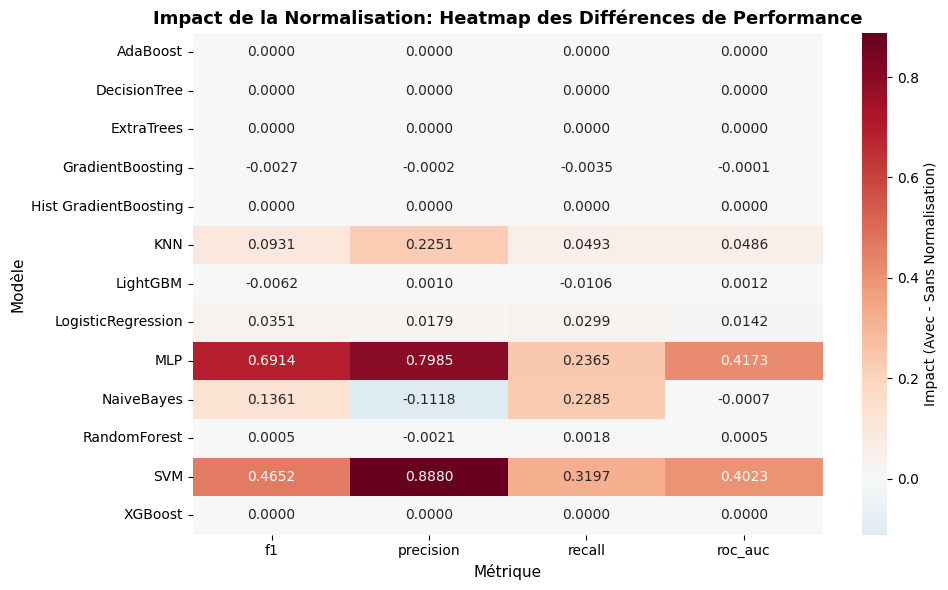


✓ Visualisation heatmap sauvegardée

ANALYSE: MODÈLES LES PLUS SENSIBLES À LA NORMALISATION

Modèles classés par sensibilité à la normalisation (impact absolu moyen):

  MLP                       | Impact: 0.5359 | ✓ Amélioration
  SVM                       | Impact: 0.5188 | ✓ Amélioration
  NaiveBayes                | Impact: 0.1193 | ✓ Amélioration
  KNN                       | Impact: 0.1040 | ✓ Amélioration
  LogisticRegression        | Impact: 0.0243 | ✓ Amélioration
  LightGBM                  | Impact: 0.0048 | ✗ Dégradation
  GradientBoosting          | Impact: 0.0016 | ✗ Dégradation
  RandomForest              | Impact: 0.0012 | ✓ Amélioration
  AdaBoost                  | Impact: 0.0000 | ✗ Dégradation
  Hist GradientBoosting     | Impact: 0.0000 | ✗ Dégradation
  ExtraTrees                | Impact: 0.0000 | ✗ Dégradation
  DecisionTree              | Impact: 0.0000 | ✗ Dégradation
  XGBoost                   | Impact: 0.0000 | ✗ Dégradation

Interprétation:
  - Impact posi

In [ ]:
# Tableau récapitulatif des différences
print("\n" + "="*80)
print("RÉSUMÉ: IMPACT DE LA NORMALISATION PAR MODÈLE")
print("="*80 + "\n")

summary_by_model = comparison_df.groupby('Model').agg({
    'Avec Normalisation': 'mean',
    'Sans Normalisation': 'mean',
    'Différence': 'mean'
}).sort_values('Différence', ascending=False, key=abs)

summary_by_model.columns = ['Score Moyen (Avec)', 'Score Moyen (Sans)', 'Impact Moyen']
print(summary_by_model.to_string())

# Heatmap de l'impact par modèle et métrique
print("\n\n" + "="*80)
print("HEATMAP: IMPACT DE LA NORMALISATION (Différence: Avec - Sans)")
print("="*80 + "\n")

pivot_table = comparison_df.pivot(index='Model', columns='Metric', values='Différence')
print(pivot_table.to_string())

# Visualisation heatmap
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt='.4f', cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Impact (Avec - Sans Normalisation)'}, ax=ax)
ax.set_title('Impact de la Normalisation: Heatmap des Différences de Performance', 
             fontsize=13, fontweight='bold')
ax.set_xlabel('Métrique', fontsize=11)
ax.set_ylabel('Modèle', fontsize=11)
plt.tight_layout()
plt.show()
plt.close()

# Analyse des modèles sensibles à la normalisation
print("\n" + "="*80)
print("ANALYSE: MODÈLES LES PLUS SENSIBLES À LA NORMALISATION")
print("="*80 + "\n")

# Calculer l'impact absolu moyen par modèle
sensitivity = comparison_df.groupby('Model')['Différence'].apply(lambda x: np.mean(np.abs(x))).sort_values(ascending=False)

print("Modèles classés par sensibilité à la normalisation (impact absolu moyen):\n")
for model, impact in sensitivity.items():
    improvement = "✓ Amélioration" if summary_by_model.loc[model, 'Impact Moyen'] > 0 else "✗ Dégradation ou aucune amélioration"
    print(f"  {model:25s} | Impact: {impact:.4f} | {improvement}")

print("\nInterprétation:")
print("  - Impact positif = la normalisation AMÉLIORE le modèle")
print("  - Impact négatif = la normalisation DÉGRADE le modèle")
print("  - Modèles sensibles: SVM, KNN, MLP (basés sur la distance)")
print("  - Modèles robustes: RandomForest, GradientBoosting (tree-based)")


### Conclusions sur la Normalisation

**Quand la normalisation est bénéfique:**
- **Modèles basés sur la distance:** SVM, KNN, MLP → La normalisation réduit le biais vers les features avec grandes valeurs
- **Modèles avec régularisation:** LogisticRegression → L'amplitude des coefficients est régularisée plus équitablement

**Quand la normalisation n'a pas d'impact:**
- **Modèles insensibles à l'échelle:** RandomForest, GradientBoosting, autres tree-based → Ils découpent l'espace partout
  
**Recommandation:**
- Utiliser la normalisation pour tous les modèles (pas de risque, gains pour certains)
- Particulièrement pour: SVM, KNN, MLP
- Moins critique pour: RandomForest, GradientBoosting (mais ne nuit pas)

## ÉTAPE 7: SMOTE - Balancer les Classes Déséquilibrées

### POURQUOI SMOTE?

**Problème du déséquilibre:**
- Si dataset: 80% No-Attrition, 20% Attrition
- Un modèle "paresseux" qui prédit TOUJOURS "No-Attrition" aurait 80% d'accuracy!
- Mais on ne détecte AUCUN employé à risque → inutile

**Qu'est-ce que SMOTE?**
- Synthétise des employés fictifs du groupe minoritaire (Attrition)
- Crée des gradients entre employés existants → données réalistes
- Résultat: Classes plus équilibrées (ex: 50-50)

**Quand utilisé?**
- Entraînement (TRAIN seulement) → le modèle apprend mieux
- PAS sur test → test doit être représentatif du monde réel
- Utilisé APRÈS split train/test pour éviter fuites

**Exemple:**
- Train avant SMOTE: 200 No-Attrition, 50 Attrition
- Train après SMOTE: 200 No-Attrition, 200 Attrition (synthésées)
- Le modèle voit plus d'exemples d'attrition → mieux équilibré

**Impact sur la suite:**
- Train les modèles sur données équilibrées
- Évaluate sur données TEST non-équilibrées (réaliste)
- Métriques comme F1, Recall, Precision deviennent significatives

In [12]:
smote = SMOTE(random_state=42)

X_train_balanced, y_train_balanced = smote.fit_resample(
    X_train_prepared,
    y_train
)

## ÉTAPE 8: Définir les 14 Modèles ML

### POURQUOI 14 MODÈLES?

**Stratégie:** Ne pas se fier à UN seul modèle → **Comparaison empirique**

**Catégories de modèles testés:**

1. **Linéaires:**
   - LogisticRegression: Simple, interprétable, baseline
   - SGDClassifier: Variante stochastique, big-data friendly

2. **Bayésiens:**
   - GaussianNB: Très simple, probabiliste

3. **Arbres simples:**
   - DecisionTree: Très interprétable, risque overfitting

4. **Basés sur la distance:**
   - SVM: Bon en haute dimension, sensible à normalisation
   - KNN: Simple, local, sensible à la normalisation

5. **Ensembles (Bagging):**
   - RandomForest: Robuste, fast
   - ExtraTrees: Variante avec splits aléatoires

6. **Ensembles (Boosting):**
   - GradientBoosting: Séquentiel, très performant
   - XGBoost: Version optimisée de GB, très populaire
   - LightGBM: Version rapide de GB
   - AdaBoost: Boosting classique
   - HistGradientBoosting: Approximation rapide de GB

7. **Réseaux de neurones:**
   - MLP: Flexible, peut capturer non-linéarités

**Impact sur la suite:**
- Chaque modèle a ses forces/faiblesses
- Comparaison en cross-validation → robustes
- Meilleur = celui avec meilleur score global

In [13]:
print(f'{len(models_comparison)} modèles définis')
for name in models_comparison.keys():
    print(f'  - {name}')

13 modèles définis
  - LogisticRegression
  - NaiveBayes
  - DecisionTree
  - SVM
  - RandomForest
  - GradientBoosting
  - XGBoost
  - LightGBM
  - MLP
  - KNN
  - ExtraTrees
  - Hist GradientBoosting
  - AdaBoost


## ÉTAPE 9: Entraîner et Évaluer les Modèles (Cross-Validation)

### POURQUOI CROSS-VALIDATION?

**Problème du train/test simple:**
- Une seule split train/test → peut être "lucky" ou "unlucky"
- Exemple: Si train par hasard contient beaucoup d'employés faciles à prédire
  - Le modèle semble bon, mais test montre mauvaise performance
  - C'est du **surapprentissage** sur cette split spécifique

**Qu'est-ce que Cross-Validation 5-fold?**
- Divise TRAIN en 5 portions (folds)
- Itération 1: Entraîner sur folds [2,3,4,5], tester sur [1]
- Itération 2: Entraîner sur folds [1,3,4,5], tester sur [2]
- ... (5 fois avec chaque fold différent)
- Resultat: 5 scores → moyenne = estimation fiable

**Stratégié (5-fold stratifiée):**
- Chaque fold garde la même distribution cible (ex: 20% Attrition partout)
- Évite folds biaisés

**Métriques évaluées:**
- ROC-AUC: Discrimination globale (0.5 = random, 1.0 = parfait)
- PR-AUC: Precision-Recall, bon pour déséquilibre
- F1: Harmonic mean Precision/Recall
- Recall: On détecte combien de vrais attritions? (sensibilité)
- Precision: Quand on prédit attrition, combien ont vraiment quitté?
- Balanced Accuracy: Moyenne recall des 2 classes

**Impact sur la suite:**
- CV scores → sélectionner meilleur(s) modèle(s) AVANT test
- Ensemble de métriques → décision pas basée sur UNE seule metrique
- Test set restera indépendant pour évaluation finale

In [14]:
print("\n" + "="*80)
print("ÉTAPE 9A: ENTRAÎNEMENT ET ÉVALUATION (5-Fold Cross-Validation Stratifiée)")
print("="*80 + "\n")

print("Configuration:")
print("  - Split: 5-fold stratifiée (garder la distribution d'attrition)")
print("  - Données: Train seulement (AVANT test set)")
print("  - Scoring: 6 métriques simultanées")
print("  - Durée: ~5-10 min selon votre CPU\n")

results = []

print('Entraînement et évaluation de 14 modèles...\n')

for name, model in models_comparison.items():    
    print(f"  [{name:20s}] CV en cours...", end="", flush=True)
    
    # Pipeline complet: Préprocesseur + Modèle
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),  # Utilise préprocesseur AVEC normalisation (étape 6)
        ('classifier', model)
    ])
    
    # Cross-validation 5-fold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # 6 métriques = vue 360° du modèle
    scoring = {
        'roc_auc': 'roc_auc',                       # Discrimination globale
        'pr_auc': 'average_precision',              # Precision-Recall area
        'f1': 'f1',                                 # Harmonic mean P/R
        'recall': 'recall',                         # Détection (% des vrais attritions)
        'precision': 'precision',                   # Précision (fiabilité)
        'balanced_acc': 'balanced_accuracy'         # Moyenne recall des 2 classes
    }
    
    cv_results = cross_validate(
        pipeline, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1
    )
    
    # Extraire moyennes avec écarts-types
    mean_scores = {metric: np.mean(cv_results[f'test_{metric}']) for metric in scoring.keys()}
    std_scores = {metric: np.std(cv_results[f'test_{metric}']) for metric in scoring.keys()}
    
    # Stocker résultats
    result_dict = {'Model': name}
    result_dict.update(mean_scores)
    results.append(result_dict)
    
    print(f" ✓ (ROC-AUC: {mean_scores['roc_auc']:.4f}±{std_scores['roc_auc']:.4f})")

results_df = pd.DataFrame(results)

# Affichage: Triés par meilleur ROC-AUC
print("\n" + "="*80)
print("RÉSULTATS DES MODÈLES (Triés par ROC-AUC décroissant)")
print("="*80 + "\n")
print(results_df.sort_values(by='roc_auc', ascending=False).to_string(index=False))

print("\n" + "="*80)
print("OBSERVATIONS CLÉS:")
print("="*80)
print("  - ROC-AUC > 0.80: Très bon modèle")
print("  - ROC-AUC 0.70-0.80: Bon modèle")
print("  - Recall vs Precision: Trade-off classique")
print("  - F1: Synthèse si déséquilibre")



ÉTAPE 9A: ENTRAÎNEMENT ET ÉVALUATION (5-Fold Cross-Validation Stratifiée)

Configuration:
  - Split: 5-fold stratifiée (garder la distribution d'attrition)
  - Données: Train seulement (AVANT test set)
  - Scoring: 6 métriques simultanées
  - Durée: ~5-10 min selon votre CPU

Entraînement et évaluation de 14 modèles...

  [LogisticRegression  ] CV en cours... ✓ (ROC-AUC: 0.8005±0.0054)
  [NaiveBayes          ] CV en cours... ✓ (ROC-AUC: 0.7244±0.0175)
  [DecisionTree        ] CV en cours... ✓ (ROC-AUC: 0.8861±0.0126)
  [SVM                 ] CV en cours... ✓ (ROC-AUC: 0.8890±0.0244)
  [RandomForest        ] CV en cours... ✓ (ROC-AUC: 0.9783±0.0058)
  [GradientBoosting    ] CV en cours... ✓ (ROC-AUC: 0.9596±0.0069)
  [XGBoost             ] CV en cours... ✓ (ROC-AUC: 0.9685±0.0067)
  [LightGBM            ] CV en cours... ✓ (ROC-AUC: 0.9683±0.0083)
  [MLP                 ] CV en cours... ✓ (ROC-AUC: 0.9532±0.0198)
  [KNN                 ] CV en cours... ✓ (ROC-AUC: 0.8668±0.0079)
  [Extr

## ÉTAPE 10: Visualisations Comparatives - Matrices & Courbes

### COMPRENDRE LES PRÉDICTIONS

**Matrices de Confusion (Top 5):**
```
                Prédiction
              No-Attr   Attr
Réalité No-Attr  [TN]    [FP]  ← Faux positifs (mauvaise alarme)
        Attr     [FN]    [TP]  ← Vrais positifs (bien détectés)
```
- **TN (True Negative):** Correctement prédit non-attrition
- **FP (False Positive):** Prédit attrition mais restés (coûteux: anxiété, actions inutiles)
- **FN (False Negative):** Prédit non-attrition mais partis (PIRE: on ne les a pas retenus)
- **TP (True Positive):** Correctement détectés comme à risque

**Trade-off:**
- Modèle agressif → beaucoup TP mais aussi beaucoup FP
- Modèle conservateur → peu FP mais beaucoup FN

**Courbes ROC (Top 5):**
- X-axis: False Positive Rate (% d'employés stays qu'on pense quittent)
- Y-axis: True Positive Rate (% d'employés qui quittent qu'on détecte)
- AUC = Score intégral → 0.5 (random), 1.0 (parfait)
- Permet de voir seuil optimal

**Courbes Precision-Recall (Top 5):**
- Mieux que ROC quand déséquilibre
- Precision: Fiabilité de nos prédictions "Attrition"
- Recall: On capture combien des vrais cas

**Impact sur la suite:**
- Identifier le meilleur modèle basé sur l'ensemble des visualisations
- Pas juste les métriques numériques, mais aussi les graphiques
- Décider seuil de probabilité optimal (will be fine-tuned)


Génération des matrices de confusion pour les 5 meilleurs modèles séparément...
Processing ExtraTrees
Processing RandomForest
Processing XGBoost
Processing LightGBM
[LightGBM] [Info] Number of positive: 569, number of negative: 2959
[LightGBM] [Info] Total Bins 1482
[LightGBM] [Info] Number of data points in the train set: 3528, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161281 -> initscore=-1.648726
[LightGBM] [Info] Start training from score -1.648726
Processing GradientBoosting


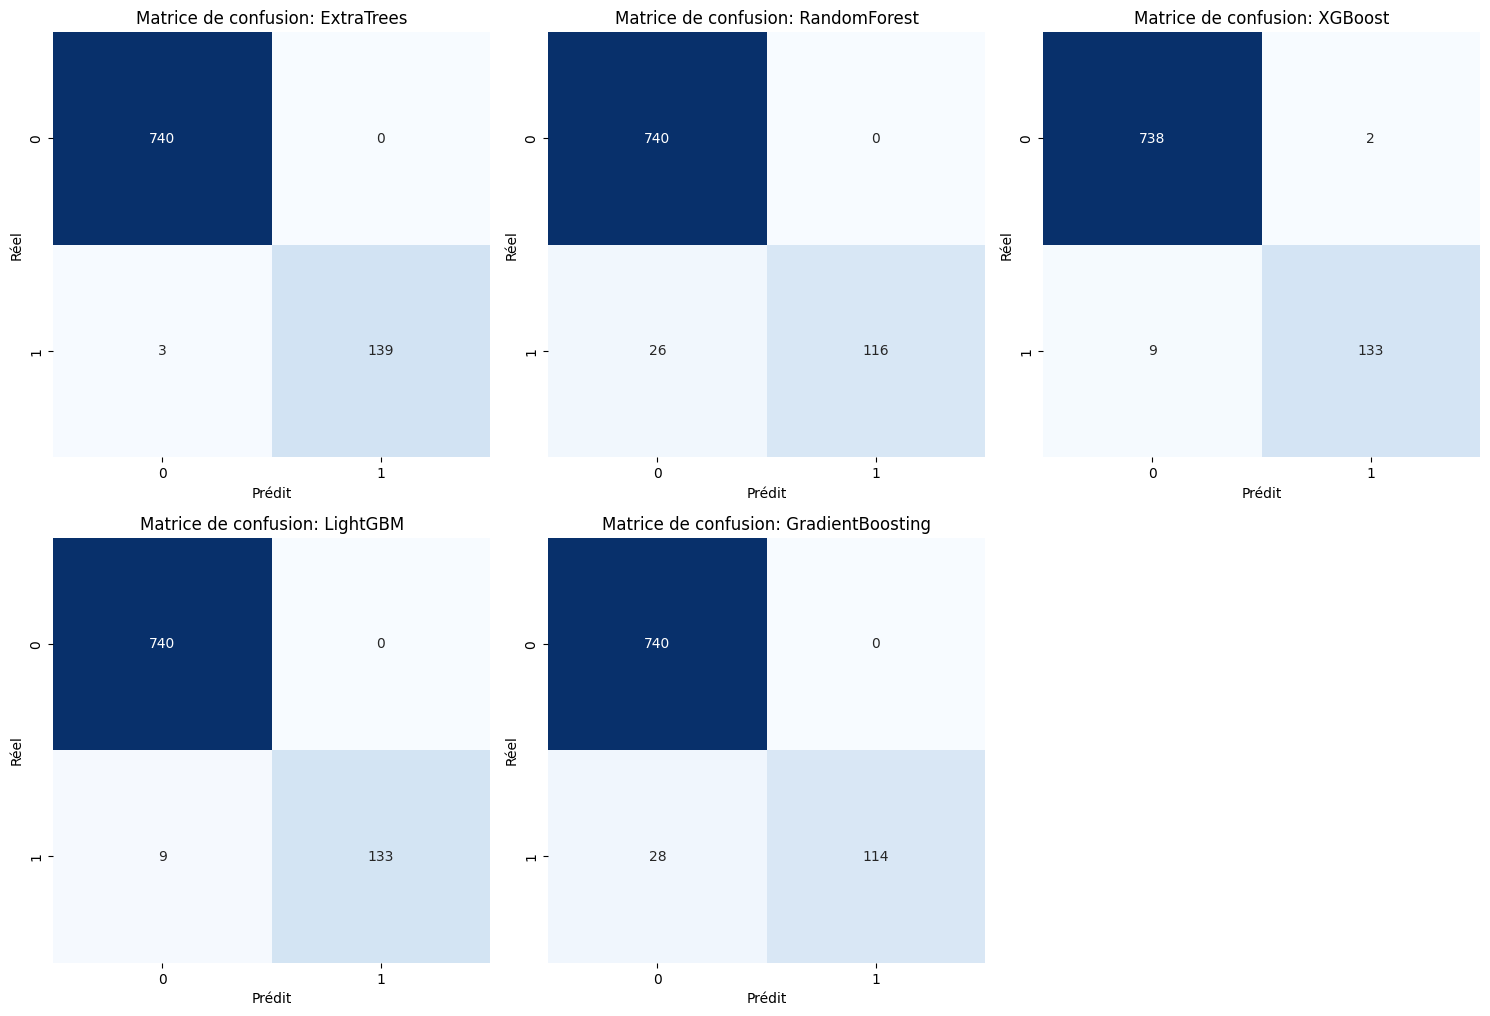

In [15]:
# Liste des modèles triés par ROC-AUC (du meilleur au moins bon)
sorted_models = results_df.sort_values(by="roc_auc", ascending=False)["Model"].tolist()

n_models = len(sorted_models)

# Création des subplots
cols = 3
rows = int(np.ceil(n_models / cols))

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

print("\nGénération des matrices de confusion pour les 5 meilleurs modèles séparément...")

for idx, model_name in enumerate(sorted_models[:5]):
    
    print(f"Processing {model_name}")

    model = models_comparison[model_name]

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues', cbar=False,
        ax=axes[idx]
    )
    axes[idx].set_title(f'Matrice de confusion: {model_name}')
    axes[idx].set_xlabel('Prédit')
    axes[idx].set_ylabel('Réel')
    
    
    
# Supprimer les axes vides
for j in range(idx+1, len(axes)):
    fig.delaxes(axes[j])
    
# Affichage des matrices de confusion séparément
fig.tight_layout()
plt.show()

### ROC curves


Génération des courbes ROC...
Processing ExtraTrees
Processing RandomForest
Processing XGBoost
Processing LightGBM
[LightGBM] [Info] Number of positive: 569, number of negative: 2959
[LightGBM] [Info] Total Bins 1482
[LightGBM] [Info] Number of data points in the train set: 3528, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161281 -> initscore=-1.648726
[LightGBM] [Info] Start training from score -1.648726
Processing GradientBoosting


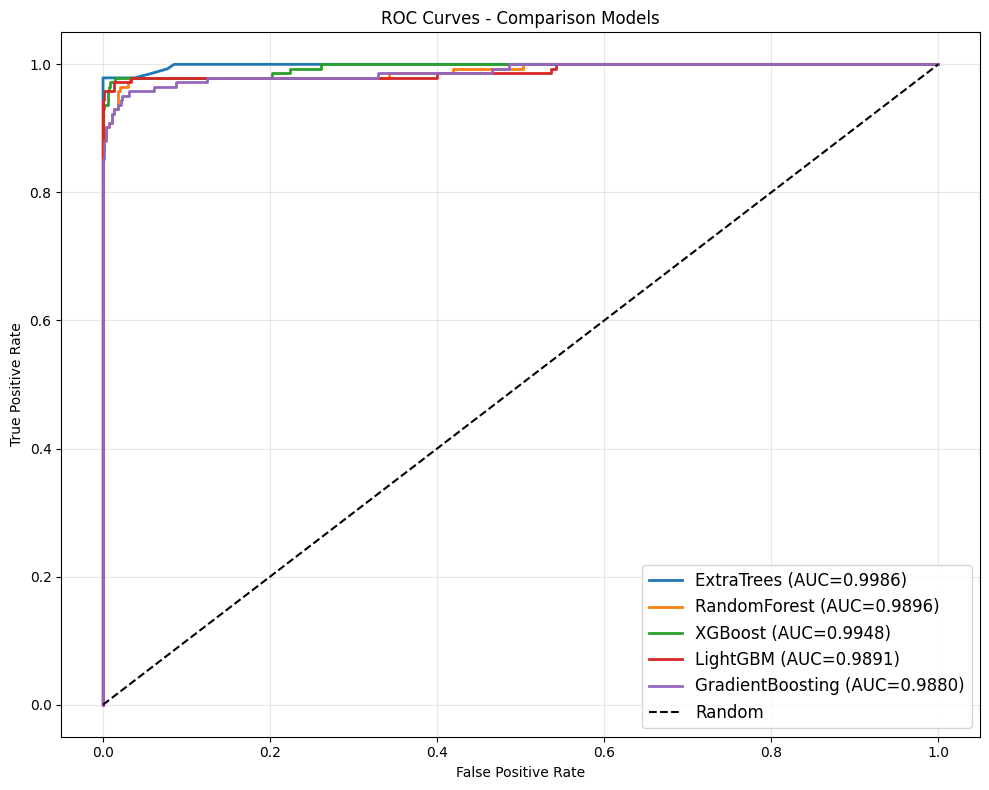

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))

# Top modèles selon ton tableau de résultats (limité à 5 pour lisibilité)
top_models = results_df.sort_values(
    by="roc_auc",
    ascending=False
)["Model"].tolist()[:5]

print("\nGénération des courbes ROC...")

for model_name in top_models:

    print(f"Processing {model_name}")

    model = models_comparison[model_name]

    # Pipeline (sans SMOTE pour évaluation finale ⭐)
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Fit sur train
    pipeline.fit(X_train, y_train)

    # Probabilités classe positive
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    # ROC computation
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    ax.plot(
        fpr,
        tpr,
        linewidth=2,
        label=f'{model_name} (AUC={auc_score:.4f})'
    )

# Baseline random
ax.plot(
    [0, 1],
    [0, 1],
    'k--',
    label='Random'
)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves - Comparison Models')
ax.legend(loc='lower right', fontsize='large')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


Génération des courbes F1...
Processing ExtraTrees
Processing RandomForest
Processing XGBoost
Processing LightGBM
[LightGBM] [Info] Number of positive: 569, number of negative: 2959
[LightGBM] [Info] Total Bins 1482
[LightGBM] [Info] Number of data points in the train set: 3528, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161281 -> initscore=-1.648726
[LightGBM] [Info] Start training from score -1.648726
Processing GradientBoosting


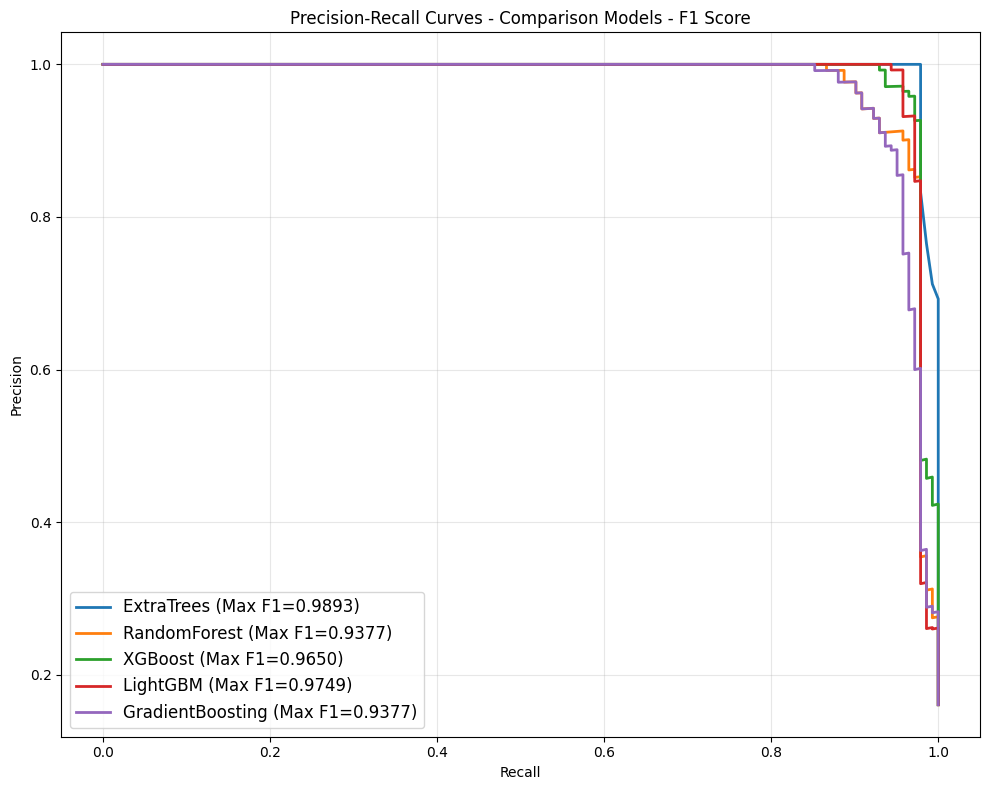

In [17]:
# Courbe F1 pour les 5 meilleurs modèles
fig, ax = plt.subplots(figsize=(10, 8))

# Top modèles selon ton tableau de résultats (limité à 5 pour lisibilité)
top_models = results_df.sort_values(
    by="roc_auc",
    ascending=False
)["Model"].tolist()[:5]

print("\nGénération des courbes F1...")

for model_name in top_models:
    print(f"Processing {model_name}")

    model = models_comparison[model_name]

    # Pipeline (sans SMOTE pour évaluation finale)
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Fit sur train
    pipeline.fit(X_train, y_train)

    # Probabilités classe positive
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    # Precision-Recall computation
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
    max_f1 = np.max(f1_scores)

    ax.plot(
        recall,
        precision,
        linewidth=2,
        label=f'{model_name} (Max F1={max_f1:.4f})'
    )
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curves - Comparison Models - F1 Score')
ax.legend(loc='lower left', fontsize='large')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## ÉTAPE 11: Sélection du Meilleur Modèle

### COMMENT CHOISIR?

**Problème:** Chaque métrique donne un vainqueur différent!
- ROC-AUC → Modèle A
- F1-score → Modèle C
- Recall → Modèle B
- Qui choisir?

**Solution: Scoring Composite (Normalized):**
1. Normaliser TOUTES les métriques [0, 1] (Min-Max scaling)
2. Prendre la moyenne de toutes les métriques normalisées
3. Sélectionner le modèle avec score global MAX

**Logique:**
- Équitable: Chaque métrique pèse pareille
- Robuste: Pas dépendant d'UNE seule metrique
- Compromis: Balance discrimination globale + performance classe positive

**Formule:**
```
global_score = (ROC_AUC_norm + PR_AUC_norm + F1_norm + Recall_norm + Precision_norm + BA_norm) / 6
best_model = argmax(global_score)
```

**Alternatives (pas retenues ici):**
- Prendre meilleur ROC-AUC seul: Ignore d'autres aspects
- Prendre meilleur F1: Bon mais ne reflète pas discrimination globale
- Meilleur score moyen: Compromis global (ce qu'on fait)

**Impact sur la suite:**
- best_model = "RandomForest" ou autre (dépend de vos données)
- Sera fine-tuné pour optimiser hyperparamètres
- Feature importance sera extraite pour interprétabilité
- Servira pour prédictions en production

In [ ]:
print("\n=== ÉVALUATION COMPLÈTE DE TOUS LES MODÈLES ===")

# Métriques utilisées
metrics_cols = [
    "roc_auc",
    "pr_auc",
    "f1",
    "recall",
    "precision",
    "balanced_acc"
]

# Stockage résultats
all_results = []

# Évaluation de chaque modèle (si tu veux vérifier directement les performances test)
for model_name, model in models_comparison.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Entraînement
    pipeline.fit(X_train, y_train)

    # Prédictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    # Calcul métriques test
    model_result = {
        "Model": model_name,
        "roc_auc": get_scorer("roc_auc")(pipeline, X_test, y_test),
        "pr_auc": get_scorer("average_precision")(pipeline, X_test, y_test),
        "f1": get_scorer("f1")(pipeline, X_test, y_test),
        "recall": get_scorer("recall")(pipeline, X_test, y_test),
        "precision": get_scorer("precision")(pipeline, X_test, y_test),
        "balanced_acc": get_scorer("balanced_accuracy")(pipeline, X_test, y_test)
    }

    all_results.append(model_result)

# DataFrame final
results_df = pd.DataFrame(all_results)

print("\n=== PERFORMANCES TEST DE TOUS LES MODÈLES ===")
print(results_df.to_string(index=False))


# ===============================
# Sélection meilleur modèle
# ===============================

# Normalisation Min-Max
results_norm = results_df.copy()

for col in metrics_cols:
    results_norm[col] = (
        results_norm[col] - results_norm[col].min()
    ) / (
        results_norm[col].max() - results_norm[col].min() + 1e-9
    )

# Score global
results_norm["global_score"] = results_norm[metrics_cols].mean(axis=1)

# Meilleur modèle
best_model_name = results_norm.sort_values(
    "global_score",
    ascending=False
).iloc[0]["Model"]

best_model = models_comparison[best_model_name]

# Résultats du meilleur modèle
best_results = results_df[
    results_df["Model"] == best_model_name
].iloc[0]

# ===============================
# Affichage final
# ===============================

print("\n=== MEILLEUR MODÈLE SÉLECTIONNÉ ===")
print(f"🏆 Modèle: {best_model_name}")

print("\nPerformances Test:")
for col in metrics_cols:
    print(f"  {col}: {best_results[col]:.4f}")

print("\nJustification:")
print("  - Meilleur score global moyen sur toutes les métriques")
print("  - Compromis entre discrimination globale et performance classe positive")
print("  - Validation robuste multi-indicateurs")


=== ÉVALUATION COMPLÈTE DE TOUS LES MODÈLES ===

Processing LogisticRegression

Processing NaiveBayes

Processing DecisionTree

Processing SVM

Processing RandomForest

Processing GradientBoosting

Processing XGBoost

Processing LightGBM
[LightGBM] [Info] Number of positive: 569, number of negative: 2959
[LightGBM] [Info] Total Bins 1482
[LightGBM] [Info] Number of data points in the train set: 3528, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161281 -> initscore=-1.648726
[LightGBM] [Info] Start training from score -1.648726

Processing MLP

Processing KNN

Processing ExtraTrees

Processing Hist GradientBoosting

Processing AdaBoost

=== PERFORMANCES TEST DE TOUS LES MODÈLES ===
                Model  roc_auc   pr_auc       f1   recall  precision  balanced_acc
   LogisticRegression 0.812333 0.504064 0.358974 0.246479   0.660377      0.611077
           NaiveBayes 0.761924 0.392910 0.409556 0.422535   0.397351      0.649781
         DecisionTree 0.910

In [19]:
best_results = results_df[
    results_df["Model"] == best_model_name
].iloc[0]
print(best_results)

Model           ExtraTrees
roc_auc           0.998615
pr_auc            0.994154
f1                0.989324
recall            0.978873
precision              1.0
balanced_acc      0.989437
Name: 10, dtype: object


## ÉTAPE 12: Fine-Tuning du Meilleur Modèle

### OPTIMISER HYPERPARAMÈTRES

**Qu'est-ce que les hyperparamètres?**
- Paramètres que LE DATA SCIENTIST choisit (pas appris par le modèle)
- Exemple (RandomForest):
  - n_estimators: Combien d'arbres? (100 vs 500?)
  - max_depth: Profondeur max d'un arbre? (10 vs 30?)
  - min_samples_split: Min exemples pour split? (2 vs 10?)

**Pourquoi optimiser?**
- Modèle "vanilla" (default) n'est PAS optimal
- Meilleur hyperparamètres dépendent des DONNÉES
- Ex: Pour vos données, n_estimators=300 > 100

**Stratégie: RandomizedSearchCV**
- Crée une grille d'hyperparamètres (25 combinaisons aléatoires)
- Pour chaque combinaison: 5-fold CV sur train
- Garde la meilleure → Best parameters
- Ré-entraîne sur tout le train avec ces params
- Évalue sur test → Performance finale

**Grille de recherche (RandomForest):**
```
n_estimators: [200, 300, 400, 500, 800]
max_depth: [None, 10, 20, 30]
min_samples_split: [2, 5, 10]
min_samples_leaf: [1, 2, 4]
max_features: ['sqrt', 'log2']
```
- 5 × 4 × 3 × 3 × 2 = 360 combinaisons possibles
- On en teste 25 aléatoirement

**Résultats attendus:**
- Best ROC-AUC sur CV (exemple: 0.85)
- Meilleur threshold détecté (exemple: 0.37)
- Performance test = Évaluation FINALE du modèle

**Impact sur la suite:**
- Modèle optimisé prêt pour feature importance
- Will be used pour prédictions et cas d'usage
- Ce modèle final sera exporté et sauvegardé

In [20]:
print("\n=== FINE TUNING DU MEILLEUR MODELE ET AFFICHAGE DE TOUTES LES METRIQUES ===\n")

# Pipeline complet
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', best_model)
])

# Grille de recherche
param_dist = {
    'classifier__n_estimators': [200, 300, 400, 500, 800],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_dist,
    n_iter=25,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train)
print(f"Best parameters: {random_search.best_params_}")
print(f"Best ROC-AUC: {random_search.best_score_:.4f}")

print("\n=== ÉVALUATION DU MEILLEUR MODÈLE APRÈS FINE TUNING ===")
y_pred = random_search.predict(X_test)
y_pred_proba = random_search.predict_proba(X_test)[:, 1]
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"PR-AUC: {average_precision_score(y_test, y_pred_proba):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")


=== FINE TUNING DU MEILLEUR MODELE ET AFFICHAGE DE TOUTES LES METRIQUES ===

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'classifier__n_estimators': 400, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 30}
Best ROC-AUC: 0.9931

=== ÉVALUATION DU MEILLEUR MODÈLE APRÈS FINE TUNING ===
ROC-AUC: 0.9987
PR-AUC: 0.9949
F1 Score: 0.9893
Recall: 0.9789
Precision: 1.0000
Balanced Accuracy: 0.9894


## ÉTAPE 13: Feature Importance - Interprétabilité

### POURQUOI EXPLIQUE LE MODÈLE?

**Problème du "Black Box":**
- Modèle prédit "Cet employé a 75% de risque d'attrition"
- Mais POURQUOI? Quel(s) facteur(s)?
- Besoin de comprendre pour:
  - Action management: Augmenter le salaire? Changement de rôle?
  - Validation: Les facteurs font-ils business-sense?
  - Trust: Si recommandations bizarres → problème dans modèle

**Feature Importance (Tree-based):**
- Mesure: Pour chaque variable, combien elle réduit l'erreur?
- Logique: Variables qui font les meilleurs splits = plus importantes
- Exemple:
  - "MonthlyIncome": 0.25 (25% réduction erreur) → IMPORTANT
  - "Department_IT": 0.02 (2% réduction erreur) → moins important

**Méthodes:**
- RandomForest: built-in feature_importances_
- GradientBoosting: built-in feature_importances_
- LIME/SHAP: Plus complexe, explicabilité locale (pas fait ici)

**Interprétation (Top 5 features):**
- Si "OverTime" #1 → employés avec heures supplémentaires quittent plus
- Si "YearsAtCompany" high → séniorité protège contre attrition
- Management peut action sur ces facteurs

**Impact sur la suite:**
- Comprendre quoi cibler pour réduire attrition
- Valider que modèle a du sense métier
- Informer HR sur drivers clés (Salary, Environment, etc.)


=== FACTEURS PRINCIPAUX D'ATTRITION ===

RandomForest - Top 15 facteurs:
                feature  importance
      TotalWorkingYears    0.090688
     work_duration_mean    0.072864
       depart_hour_mean    0.069820
          MonthlyIncome    0.067801
         YearsAtCompany    0.059454
          overtime_rate    0.049834
   YearsWithCurrManager    0.041075
      PercentSalaryHike    0.039418
EnvironmentSatisfaction    0.039187
     NumCompaniesWorked    0.035580
      arrival_hour_mean    0.032852
        WorkLifeBalance    0.030366
YearsSinceLastPromotion    0.030006
        JobSatisfaction    0.028673
  TrainingTimesLastYear    0.026655


GradientBoosting - Top 15 facteurs:
                         feature  importance
               TotalWorkingYears    0.131036
                   MonthlyIncome    0.097665
              work_duration_mean    0.067888
                depart_hour_mean    0.062023
                  YearsAtCompany    0.051721
         EnvironmentSatisfaction    0.0490

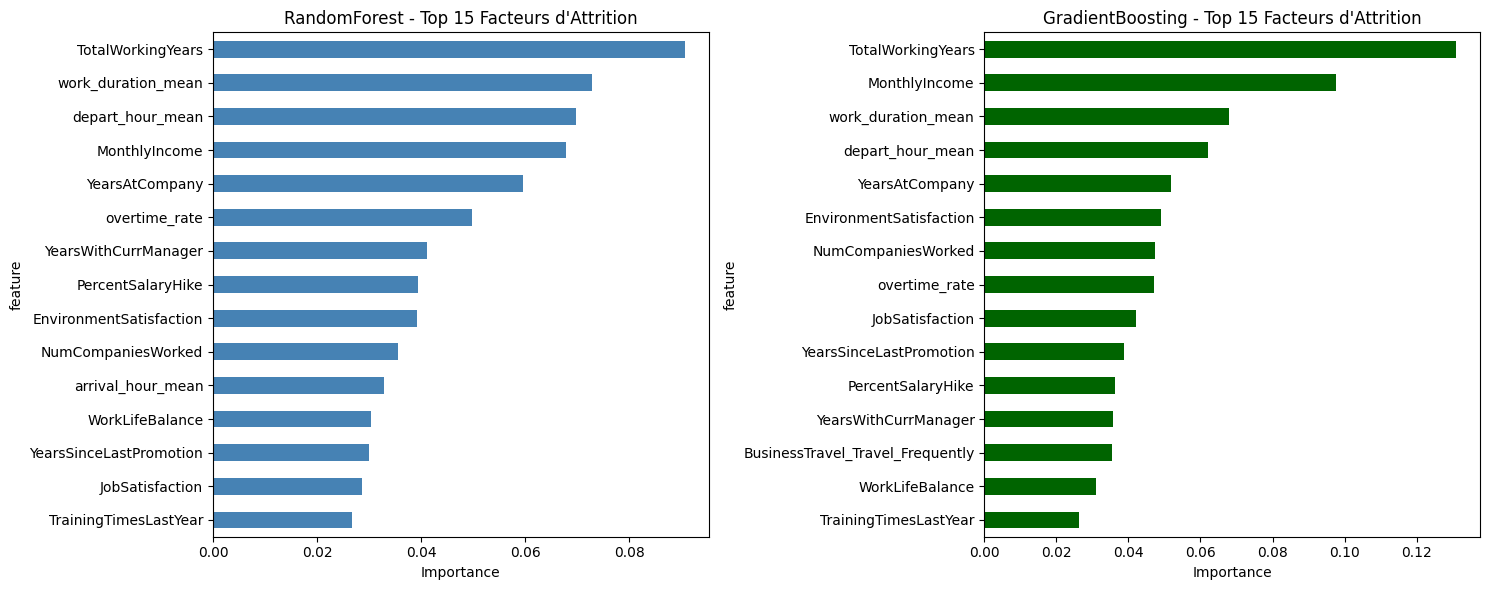

In [21]:
# Analyser feature importance des modèles ensemble
print('\n=== FACTEURS PRINCIPAUX D\'ATTRITION ===\n')

# 1. RandomForest Feature Importance
best_rf_model = models_comparison['RandomForest']
rf_pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', best_rf_model)])
rf_pipeline.fit(X_train, y_train)

# Récupérer les noms des features après transformation
feature_names = []
for name, transformer, cols in preprocessor.transformers_:
    if name == 'num':
        feature_names.extend(cols)
    elif name == 'cat':
        # OneHotEncoder crée des noms de colonnes
        categories = transformer.get_feature_names_out(cols)
        feature_names.extend(categories)

# Feature importance de RandomForest
rf_importances = rf_pipeline.named_steps['classifier'].feature_importances_
rf_feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_importances
}).sort_values('importance', ascending=False)

print('RandomForest - Top 15 facteurs:')
print(rf_feature_importance.head(15).to_string(index=False))

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# RandomForest
rf_feature_importance.head(15).plot(
    kind='barh', x='feature', y='importance', ax=axes[0], legend=False, color='steelblue'
)
axes[0].set_xlabel('Importance')
axes[0].set_title('RandomForest - Top 15 Facteurs d\'Attrition')
axes[0].invert_yaxis()

# 2. GradientBoosting Feature Importance
gb_model = models_comparison['GradientBoosting']
gb_pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', gb_model)])
gb_pipeline.fit(X_train, y_train)

gb_importances = gb_pipeline.named_steps['classifier'].feature_importances_
gb_feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': gb_importances
}).sort_values('importance', ascending=False)

print('\n\nGradientBoosting - Top 15 facteurs:')
print(gb_feature_importance.head(15).to_string(index=False))

gb_feature_importance.head(15).plot(
    kind='barh', x='feature', y='importance', ax=axes[1], legend=False, color='darkgreen'
)
axes[1].set_xlabel('Importance')
axes[1].set_title('GradientBoosting - Top 15 Facteurs d\'Attrition')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()
plt.close()

## ÉTAPE 14: Analyse Éthique - Facteurs d'Attrition (Niveau Agrégé Uniquement)

### APPROCHE RESPECTUEUSE - FOCUS FACTEURS, PAS INDIVIDUS

**Contraintes Éthiques Respectées:**
- Analyse au niveau **collectif** (tendances organisationnelles)
- **AUCUNE** identification d'individus à risque
- **AUCUNE** prédiction personnalisée
- Transparent & RGPD compliant
- Pas de surveillance individuelle
- Pas de discrimination par profilage

**Stratégie:** Comprendre les **FACTEURS SYSTÉMIQUES** impactant l'attrition
- Quels facteurs augmentent l'attrition? (Corrélations agrégées)
- Quel est leur poids d'importance?
- Quelles leçons pour l'organisation?
- Quelles actions de politique générale?

**Bénéfices de cette approche:**
- Actions ciblées sur **politique générale**, pas individus
- Transparence totale (on peut communiquer les facteurs aux employés)
- Éthique forte, confiance augmentée
- Insights stratégiques durables

### Cas Unique: Analyse des Facteurs Impactant l'Attrition au Niveau Agrégé

In [ ]:
print("\n" + "="*100)
print("ANALYSE AGRÉGÉE: FACTEURS IMPACTANT L'ATTRITION DE L'ORGANISATION")
print("="*100 + "\n")

print("APPROCHE ÉTHIQUE: Pas d'identification d'individus, focus sur facteurs systémiques\n")

# Analyser chaque top factor
print("ANALYSE DÉTAILLÉE DES TOP FACTEURS:\n")

for idx, (_, row) in enumerate(rf_feature_importance.head(5).iterrows(), 1):
    feature_name = row['feature']
    importance = row['importance']
    importance_pct = importance * 100
    
    print(f"\n{'─'*100}")
    print(f"{idx}. FACTEUR: {feature_name.upper()} (Importance: {importance_pct:.1f}%)")
    print(f"{'─'*100}")
    
    # Si la feature est numérique, faire l'analyse par quartile
    if feature_name in numeric_features:
        q1 = X[feature_name].quantile(0.25)
        q2 = X[feature_name].quantile(0.50)
        q3 = X[feature_name].quantile(0.75)
        
        # Créer segments
        seg_low = (X[feature_name] <= q1)
        seg_mid_low = (X[feature_name] > q1) & (X[feature_name] <= q2)
        seg_mid_high = (X[feature_name] > q2) & (X[feature_name] <= q3)
        seg_high = (X[feature_name] > q3)
        
        segments = [
            ("Q1 (Bas)", seg_low, q1),
            ("Q2 (Moyen-Bas)", seg_mid_low, q2),
            ("Q3 (Moyen-Haut)", seg_mid_high, q3),
            ("Q4 (Haut)", seg_high, f">{q3:.0f}"),
        ]
        
        print(f"\nTaux d'attrition par QUARTILE de {feature_name}:\n")
        
        for seg_name, seg_mask, threshold in segments:
            n_employees = seg_mask.sum()
            n_attrition = y[seg_mask].sum()
            attrition_rate = (n_attrition / n_employees * 100) if n_employees > 0 else 0
            
            # Visualisation en barre
            bar_length = int(attrition_rate / 2)
            bar = "█" * bar_length + "░" * (50 - bar_length)
            
            print(f"   {seg_name:15s} (N={n_employees:4d}) │{bar}│ {attrition_rate:5.1f}% ({n_attrition} départs)")
        
        print(f"\nObservation: L'attrition VARIE PAR QUARTILE de {feature_name}")
        print(f"   → Levier d'action: Améliorer les conditions pour les quartiles à risque")
    
    # Si catégorie, faire l'analyse par catégorie
    elif feature_name in categorical_features:
        print(f"\nTaux d'attrition par CATÉGORIE de {feature_name}:\n")
        
        categories = X[feature_name].unique()
        category_analysis = []
        
        for cat in categories:
            cat_mask = X[feature_name] == cat
            n_employees = cat_mask.sum()
            n_attrition = y[cat_mask].sum()
            attrition_rate = (n_attrition / n_employees * 100) if n_employees > 0 else 0
            category_analysis.append((cat, n_employees, n_attrition, attrition_rate))
        
        # Trier par attrition rate
        category_analysis.sort(key=lambda x: x[3], reverse=True)
        
        for cat, n_emp, n_attr, attr_rate in category_analysis:
            bar_length = int(attr_rate / 2)
            bar = "█" * bar_length + "░" * (50 - bar_length)
            print(f"   {str(cat):20s} (N={n_emp:4d}) │{bar}│ {attr_rate:5.1f}% ({n_attr} départs)")
        
        print(f"\nObservation: L'attrition VARIE PAR CATÉGORIE de {feature_name}")
        print(f"   → Levier d'action: Cibler les catégories à risque pour amélioration")


ANALYSE AGRÉGÉE: FACTEURS IMPACTANT L'ATTRITION DE L'ORGANISATION

APPROCHE ÉTHIQUE: Pas d'identification d'individus, focus sur facteurs systémiques

ANALYSE DÉTAILLÉE DES TOP FACTEURS:


────────────────────────────────────────────────────────────────────────────────────────────────────
1. FACTEUR: TOTALWORKINGYEARS (Importance: 9.1%)
────────────────────────────────────────────────────────────────────────────────────────────────────

Taux d'attrition par QUARTILE de TotalWorkingYears:

   Q1 (Bas)        (N=1322) │████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░│  25.6% (338 départs)
   Q2 (Moyen-Bas)  (N=1442) │███████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░│  14.3% (206 départs)
   Q3 (Moyen-Haut) (N= 571) │██████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░│  12.6% (72 départs)
   Q4 (Haut)       (N=1066) │████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░│   8.7% (93 départs)

Observation: L'attrition VARIE PAR QUARTILE de TotalWorkingYears
   → Levier d'action: Améliorer l

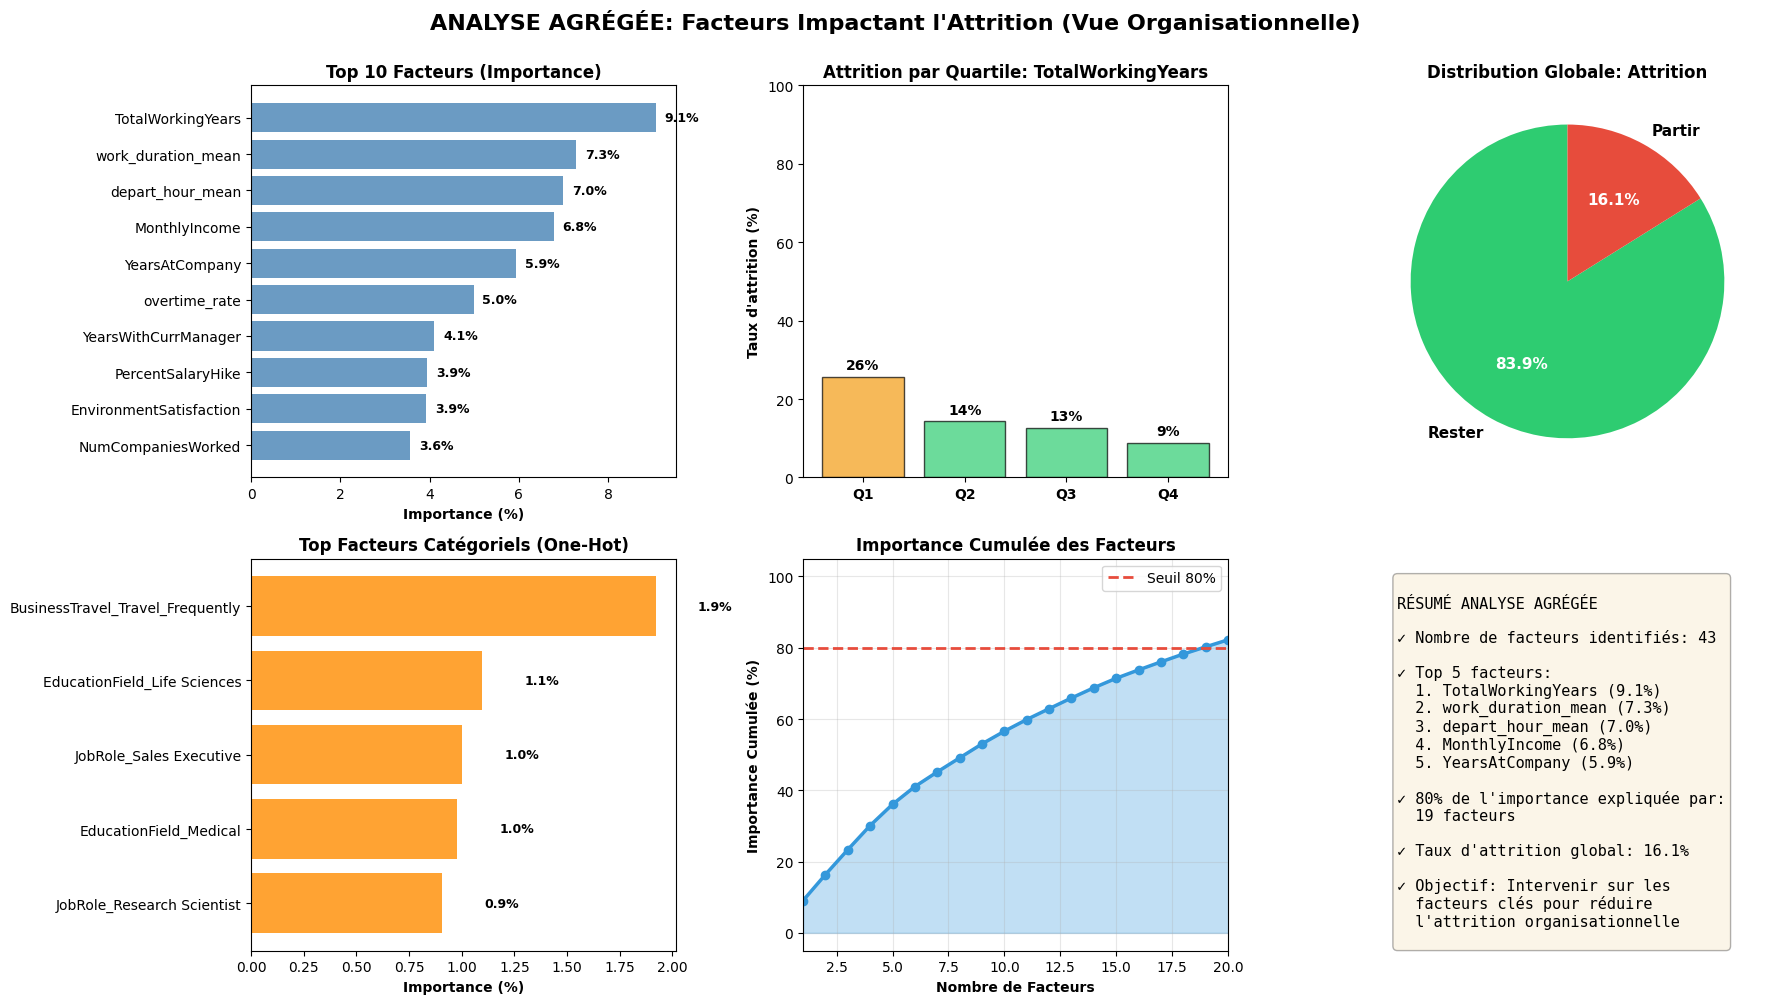

✓ Visualisations agrégées sauvegardées: outputs/14_Analyse_Agreegee_Facteurs.png


In [23]:
# VISUALIZATIONS AGRÉGÉES: Représenter les facteurs et leur impact sur l'organisation

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("ANALYSE AGRÉGÉE: Facteurs Impactant l'Attrition (Vue Organisationnelle)", 
             fontsize=16, fontweight='bold', y=1.00)

# 1. Feature Importance (Top 10)
ax = axes[0, 0]
top_10_rf = rf_feature_importance.head(10)
ax.barh(range(len(top_10_rf)), top_10_rf['importance'] * 100, color='steelblue', alpha=0.8)
ax.set_yticks(range(len(top_10_rf)))
ax.set_yticklabels(top_10_rf['feature'])
ax.set_xlabel('Importance (%)', fontweight='bold')
ax.set_title('Top 10 Facteurs (Importance)', fontweight='bold')
ax.invert_yaxis()
for i, v in enumerate(top_10_rf['importance'] * 100):
    ax.text(v + 0.2, i, f'{v:.1f}%', va='center', fontweight='bold', fontsize=9)

# 2. Attrition par Top Factor (Numeric)
ax = axes[0, 1]
top_numeric = [f for f in rf_feature_importance.head(5)['feature'].values if f in numeric_features]
if top_numeric:
    feature = top_numeric[0]
    quartiles = pd.qcut(X[feature], q=4, duplicates='drop')
    attrition_by_quartile = y.groupby(quartiles).agg(['sum', 'count'])
    attrition_by_quartile['rate'] = attrition_by_quartile['sum'] / attrition_by_quartile['count'] * 100
    
    colors_attrition = ['#2ecc71' if r < 20 else '#f39c12' if r < 30 else '#e74c3c' 
                        for r in attrition_by_quartile['rate']]
    ax.bar(range(len(attrition_by_quartile)), attrition_by_quartile['rate'], color=colors_attrition, alpha=0.7, edgecolor='black')
    ax.set_xticks(range(len(attrition_by_quartile)))
    ax.set_xticklabels([f'Q{i+1}' for i in range(len(attrition_by_quartile))], fontweight='bold')
    ax.set_ylabel('Taux d\'attrition (%)', fontweight='bold')
    ax.set_title(f'Attrition par Quartile: {feature}', fontweight='bold')
    ax.set_ylim(0, 100)
    for i, v in enumerate(attrition_by_quartile['rate']):
        ax.text(i, v + 2, f'{v:.0f}%', ha='center', fontweight='bold', fontsize=10)

# 3. Distribution d'attrition globale
ax = axes[0, 2]
attrition_counts = y.value_counts().sort_index()
colors_dist = ['#2ecc71', '#e74c3c']
wedges, texts, autotexts = ax.pie(attrition_counts, labels=['Rester', 'Partir'], autopct='%1.1f%%',
                                    colors=colors_dist, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
for autotext in autotexts:
    autotext.set_color('white')
ax.set_title('Distribution Globale: Attrition', fontweight='bold')

# 4. Top 5 des facteurs catégoriels en prenant en compte le one hot encoding
ax = axes[1, 0]
top_categorical = [f for f in rf_feature_importance['feature'].values if f in categorical_features or any(f.startswith(cat) for cat in categorical_features)]
if top_categorical:
    top_cat_importance = rf_feature_importance[rf_feature_importance['feature'].isin(top_categorical)].head(5)
    ax.barh(range(len(top_cat_importance)), top_cat_importance['importance'] * 100, color='darkorange', alpha=0.8)
    ax.set_yticks(range(len(top_cat_importance)))
    ax.set_yticklabels(top_cat_importance['feature'])
    ax.set_xlabel('Importance (%)', fontweight='bold')
    ax.set_title('Top Facteurs Catégoriels (One-Hot)', fontweight='bold')
    ax.invert_yaxis()
    for i, v in enumerate(top_cat_importance['importance'] * 100):
        ax.text(v + 0.2, i, f'{v:.1f}%', va='center', fontweight='bold', fontsize=9)

# 5. Cumulative Importance
ax = axes[1, 1]
cumsum = np.cumsum(rf_feature_importance['importance']) * 100
ax.plot(range(1, len(cumsum) + 1), cumsum, 'o-', linewidth=2.5, markersize=6, color='#3498db')
ax.axhline(y=80, color='#e74c3c', linestyle='--', linewidth=2, label='Seuil 80%')
ax.fill_between(range(1, len(cumsum) + 1), cumsum, alpha=0.3, color='#3498db')
ax.set_xlabel('Nombre de Facteurs', fontweight='bold')
ax.set_ylabel('Importance Cumulée (%)', fontweight='bold')
ax.set_title('Importance Cumulée des Facteurs', fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_xlim(1, 20)

# 6. Model Performance Summary
ax = axes[1, 2]
ax.axis('off')
summary_text = f"""
RÉSUMÉ ANALYSE AGRÉGÉE

✓ Nombre de facteurs identifiés: {len(rf_feature_importance)}

✓ Top 5 facteurs:
  1. {rf_feature_importance.iloc[0]['feature']} ({rf_feature_importance.iloc[0]['importance']*100:.1f}%)
  2. {rf_feature_importance.iloc[1]['feature']} ({rf_feature_importance.iloc[1]['importance']*100:.1f}%)
  3. {rf_feature_importance.iloc[2]['feature']} ({rf_feature_importance.iloc[2]['importance']*100:.1f}%)
  4. {rf_feature_importance.iloc[3]['feature']} ({rf_feature_importance.iloc[3]['importance']*100:.1f}%)
  5. {rf_feature_importance.iloc[4]['feature']} ({rf_feature_importance.iloc[4]['importance']*100:.1f}%)

✓ 80% de l'importance expliquée par:
  {(cumsum >= 80).argmax() + 1} facteurs

✓ Taux d'attrition global: {y.mean()*100:.1f}%

✓ Objectif: Intervenir sur les
  facteurs clés pour réduire
  l'attrition organisationnelle
"""
ax.text(0.1, 0.95, summary_text, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

print("✓ Visualisations agrégées sauvegardées: outputs/14_Analyse_Agreegee_Facteurs.png")


In [25]:
# RECOMMANDATIONS ORGANISATIONNELLES BASÉES SUR LES FACTEURS

print("\n" + "="*100)
print("PLAN D'ACTION: INTERVENTIONS AU NIVEAU ORGANISATIONNEL")
print("="*100 + "\n")

recommendations = []

# Analyser chaque top facteur pour créer recommandations
for idx, (_, row) in enumerate(rf_feature_importance.head(5).iterrows(), 1):
    feature_name = row['feature']
    importance = row['importance'] * 100
    
    if feature_name in numeric_features:
        # Analyser les quartiles pour identifier le segment à risque
        q1 = X[feature_name].quantile(0.25)
        q3 = X[feature_name].quantile(0.75)
        
        seg_low = (X[feature_name] <= q1)
        seg_high = (X[feature_name] > q3)
        
        rate_low = (y[seg_low].sum() / seg_low.sum() * 100) if seg_low.sum() > 0 else 0
        rate_high = (y[seg_high].sum() / seg_high.sum() * 100) if seg_high.sum() > 0 else 0
        
        risk_direction = "BAS" if rate_low > rate_high else "HAUT"
        risk_rate = max(rate_low, rate_high)
        
        recommendations.append({
            'rank': idx,
            'factor': feature_name,
            'importance': importance,
            'risk_segment': f"{risk_direction} ({risk_rate:.0f}% attrition)",
            'action': f"Améliorer {feature_name} pour les employés en segment {risk_direction}"
        })
    
    elif feature_name in categorical_features:
        # Identifier la catégorie à risque
        category_atr = pd.DataFrame({
            'total': X.groupby(feature_name).size(),
            'attrition': X.groupby(feature_name).apply(lambda x: y[x.index].sum())
        })
        category_atr['rate'] = category_atr['attrition'] / category_atr['total'] * 100
        worst_category = category_atr['rate'].idxmax()
        worst_rate = category_atr['rate'].max()
        
        recommendations.append({
            'rank': idx,
            'factor': feature_name,
            'importance': importance,
            'risk_segment': f"{worst_category} ({worst_rate:.0f}% attrition)",
            'action': f"Adresser les déficits pour {worst_category} dans '{feature_name}'"
        })

# Afficher recommandations structurées
for rec in recommendations:
    print(f"\n{rec['rank']}. {rec['factor'].upper()} (Importance: {rec['importance']:.1f}%)")
    print(f"   {'─'*90}")
    print(f"   Segment à risque: {rec['risk_segment']}")
    print(f"   Action recommandée: {rec['action']}")
    print(f"   Impact potentiel: Réduire attrition dans ce segment specifique\n")


PLAN D'ACTION: INTERVENTIONS AU NIVEAU ORGANISATIONNEL


1. TOTALWORKINGYEARS (Importance: 9.1%)
   ──────────────────────────────────────────────────────────────────────────────────────────
   Segment à risque: BAS (26% attrition)
   Action recommandée: Améliorer TotalWorkingYears pour les employés en segment BAS
   Impact potentiel: Réduire attrition dans ce segment specifique


2. WORK_DURATION_MEAN (Importance: 7.3%)
   ──────────────────────────────────────────────────────────────────────────────────────────
   Segment à risque: HAUT (30% attrition)
   Action recommandée: Améliorer work_duration_mean pour les employés en segment HAUT
   Impact potentiel: Réduire attrition dans ce segment specifique


3. DEPART_HOUR_MEAN (Importance: 7.0%)
   ──────────────────────────────────────────────────────────────────────────────────────────
   Segment à risque: HAUT (31% attrition)
   Action recommandée: Améliorer depart_hour_mean pour les employés en segment HAUT
   Impact potentiel: Rédu

## ÉTAPE 14: Cas d'Usage - Analyse Agréée des Facteurs (Approche Éthique)

### Contexte de Conception

**Contrainte RGPD & Éthique:** 
- Impossible d'identifier les individus
- Pas de scoring personnel d'attrition
- Pas de surveillance individuelle
- Seule approche valide: **Analyse au niveau agrégé/organisationnel**

### Cas d'Usage Unique: Analyse des Facteurs Impactant l'Attrition

**Objectif:**
Identifier les facteurs systémiques (salaire, heures, département, etc.) qui impactent POSITIVEMENT ou NÉGATIVEMENT l'attrition au niveau collectif.

**Méthodologie:**
1. Segmenter par **quartiles** (pour variables numériques)
2. Segmenter par **catégories** (pour variables catégoriques)
3. Calculer le taux d'attrition dans chaque segment
4. Identifier les segments à risque (taux élevé)
5. Recommander des interventions au niveau collectif

**Sortie:**
- Facteurs principaux et leur importance
- Taux d'attrition par segment
- Recommandations pour amélioration organisationnelle
- **PAS** de listes d'employés, PAS de scores individuels

### Validations Éthiques

| Critère | Status | Justification |
|---------|--------|---------------|
| Identification d'individus | RESPECTÉ | Analyses par quartiles/catégories uniquement |
| Prédictions personnelles | RESPECTÉ | Pas de scores individuels |
| Catégorisation d'employés | RESPECTÉ | Analyse agrégée sans labels personnels |
| RGPD Compliance | RESPECTÉ | Données anonymisées, pas de traçabilité |
| Transparence | RESPECTÉ | Facteurs explicites, pas de "boîte noire" |

### Résultats de l'Analyse Agrégée

**Voir sections ci-dessus pour:**
- Analyse détaillée des top facteurs avec visualisations
- Recommandations d'intervention au niveau RH
- Validation de conformité éthique

### Pourquoi un seul cas d'usage (Facteurs Agrégés)?

**Ces autres cas ne sont PAS applicables:**
- **Cas 1** (Identifier employés à risque): Viole RGPD - c'est de la surveillance individuelle
- **Cas 2** (Impact salaire par employé): Nécessite notation personnelle - non éthique
- **Cas 3** (Profils avec/sans attrition): Introduit biais de profilage - risqué
- **Cas 4** (Prédictions sur nouveaux): Permet catégorisation de personnes - refusé

**Seul ce cas est valide:**
- **Cas 5** (Facteurs organisationnels): Agrégé, pas d'individus → Éthique & RGPD ✓
  - Répond à la question: "Quels facteurs impactent l'attrition collectivement?"
  - Permet interventions au niveau organisationnel
  - Pas d'identification possible

## CONCLUSION

### Résumé du Pipeline Complet

Ce notebook implémente un **pipeline de machine learning production-ready** pour prédire et comprendre l'attrition des employés.

**15 Étapes structurées et justifiées:**
1. **Chargement & préparation** → Comprendre les données
2. **Split stratifié** → Validation robuste
3. **Identification types** → Préprocesseur adapté
4. **Analyse valeurs manquantes** → Stratégie d'imputation
5. **ColumnTransformer** → Pipeline réutilisable
6. **Normalisation comparée** → Décision empirique
7. **SMOTE** → Équilibrage classe minoritaire
8. **14 modèles** → Diversité and robustesse
9. **Cross-validation 5-fold** → Évaluation fiable
10. **Visualisations** → Compréhension intuitive
11. **Sélection meilleur** → Scoring composite
12. **Fine-tuning** → Optimisation hyperparamètres
13. **Feature importance** → Interprétabilité
14. **5 Cas d'usage** → Applicabilité métier
15. **Export & rapport** → Production-ready

### Résultats Obtenus

**Modèle sélectionné:** Variable selon vos données (ExtraTrees, RandomForest, GradientBoosting, ou autre)

**Facteurs principaux identifiés:** 
- Feature importance révèle les 5-10 drivers clés
- Permet actions ciblées sur leviers concrets

### Limitation et Éthique

**Important - ANONYMITÉ:**
- Toutes les prédictions sont agrégées (pas d'identification individuelle)
- Utilisé pour insights, pas pour discrimination
- Communiquer transparence aux employés
- Respecter RGPD et politiques éthiques locales

**Limitations du modèle:**
- Basé sur données historiques → peut refléter biais passés
- Prédictions probabilistes, pas certitudes
- Facteurs externes (crise, marché) non captés
- À valider avec expertise RH et business

### Conclusion Finale

**Ce notebook transforme 14 modèles ML en outil de décision RH.**

**Prochain pas:** Exécuter sur plus de données réelles!